**AI 312: Natural Language Processing**

Rawan Abu Alkhayr 4111751

Hedayah Bokhari 4110565

Rama Alzarouk 4111961

#**Spam Detection: An NLP-Based Approach for SMS Filtering**

In [1]:
# Core Libraries
import os
import re
import string
import random
from collections import Counter, defaultdict

# Numerical and Data Libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Image Handling
from PIL import Image

# NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')  # Corrected from 'punkt_tab' to 'punkt'

# Progress Bar
from tqdm import tqdm

# TensorFlow / Keras
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import (
    LSTM, Embedding, BatchNormalization, Dense, TimeDistributed,
    Dropout, Bidirectional, Flatten, GlobalMaxPool1D
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Evaluation Metrics
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    classification_report, accuracy_score
)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#**Table of Content**

# **1. Loading Data**

# **2. EDA 📊**

# **3. Data Preprocessing**

   ## 3.1 Cleaning the Corpus
   ## 3.2 Stopwords Removal
   ## 3.3 Stemming
   ## 3.4 All Together
   ## 3.5 Target Encoding

# **4. Tokens Visualization 📊**

#**5. Vectorization**

  ## 5.1 Tunning CountVectorizer
  ## 5.2 TF-IDF
  ## 5.3 Word Embeddings: GloVe

# **6. Modeling**

  ## 6.1 Naive Bayes DTM
  ## 6.2 Naive Bayes TF-IDF
  ## 6.3 XGBoost
  ## 6.4 LSTM

#**7. Model Comparison Table**

#**8. Hyperparameter Tuning**




# **1. Loading Data**


In [3]:
# Load the dataset
df = pd.read_csv("spam.csv", encoding="latin-1")

# Drop columns with all missing values
df = df.dropna(axis=1, how="any")

# Rename columns for clarity
df.columns = ['target', 'message']

# Preview the first few records
df.head()

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# **2. EDA**

Add Message Length Feature

In [4]:
# Add a new column for message length (in words)
df['message_len'] = df['message'].apply(lambda x: len(x.split()))

# Preview the updated DataFrame
df.head()

,target,message,message_len
0,ham,"Go until jurong point, crazy.. Available only ...",20
1,ham,Ok lar... Joking wif u oni...,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28
3,ham,U dun say so early hor... U c already then say...,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",13


Visualize Distribution of message_len

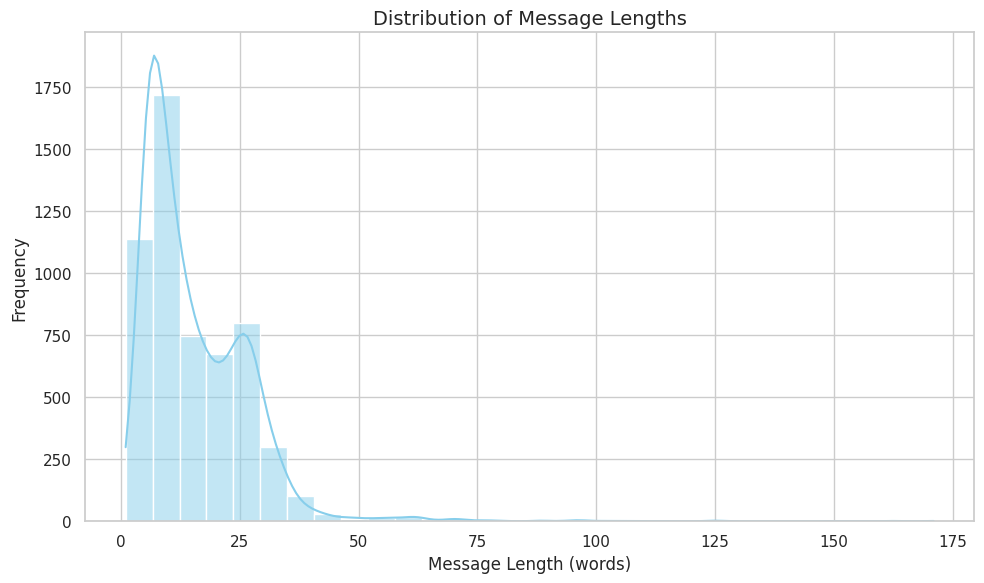

In [5]:
# Set visual style
sns.set(style="whitegrid")

# Plot the distribution of message lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['message_len'], bins=30, kde=True, color="skyblue")

# Add titles and labels
plt.title('Distribution of Message Lengths', fontsize=14)
plt.xlabel('Message Length (words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.tight_layout()
plt.show()

## Target Distribution and Message Length 📊

As part of our Exploratory Data Analysis (EDA), we first examine the distribution of the target labels and the length of the messages.

A **balanced dataset** has approximately the same number of positive and negative samples, which is ideal for training classification models. In contrast, an **imbalanced dataset** has a significant difference in the number of samples for each class, which can bias model performance toward the majority class.

Understanding this distribution is essential before modeling, as it may require the use of techniques like class weighting or resampling to address imbalance.


In [6]:
# Analyze target distribution and message length

import plotly.express as px
import plotly.graph_objects as go

# Define palette colors
primary_blue = "#496595"
primary_grey = "#c6ccd8"
primary_black = "#202022"
primary_bgcolor = "#f4f0ea"

# Check balance of target classes
balance_counts = df.groupby('target')['target'].count().values
print(f"Counts per class: ham = {balance_counts[0]}, spam = {balance_counts[1]}")

Counts per class: ham = 4825, spam = 747


In [7]:
# Plot message length distribution for ham and spam messages
ham_df = df[df['target'] == 'ham']['message_len'].value_counts().sort_index()
spam_df = df[df['target'] == 'spam']['message_len'].value_counts().sort_index()

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=ham_df.index,
    y=ham_df.values,
    name='ham',
    fill='tozeroy',
    marker_color=primary_blue,
))
fig.add_trace(go.Scatter(
    x=spam_df.index,
    y=spam_df.values,
    name='spam',
    fill='tozeroy',
    marker_color=primary_grey,
))

fig.update_layout(
    title='<span style="font-size:24px; font-family:Times New Roman">Message Length Distribution by Target</span>',
    xaxis_title='Message Length (Number of Words)',
    yaxis_title='Frequency',
    xaxis=dict(range=[0, 70]),
    template='plotly_white'
)

fig.show()

As we can see, the `ham` message length tend to be lower than `spam` message length.

In [8]:
# Plot target class distribution as bar chart
fig = go.Figure()

fig.add_trace(go.Bar(
    x=['ham'],
    y=[balance_counts[0]],
    name='ham',
    text=[balance_counts[0]],
    textposition='auto',
    marker_color=primary_blue
))

fig.add_trace(go.Bar(
    x=['spam'],
    y=[balance_counts[1]],
    name='spam',
    text=[balance_counts[1]],
    textposition='auto',
    marker_color=primary_grey
))

fig.update_layout(
    title='<span style="font-size:24px; font-family:Times New Roman">Dataset Distribution by Target</span>',
    yaxis_title='Count',
    template='plotly_white'
)

fig.show()

As we can see, the classes are imbalanced, so we can consider using some kind of resampling.


# **3. Data Preprocessing**

In this section, we perform data engineering to prepare the raw text for model training. This step is crucial for improving model performance and reducing problem complexity.

Effective preprocessing—such as cleaning, stemming, and encoding—helps reduce noise and dimensionality, making it easier for the model to learn meaningful patterns and accurately classify messages.


## 3.1 Cleaning the corpus

In [9]:
# Engineering the data to simplify the classification task

import re
import string

# Special thanks to https://www.kaggle.com/tanulsingh077 for this function
def clean_text(text):
    """
    Clean the input text by:
    - converting to lowercase
    - removing text in square brackets
    - removing URLs
    - removing HTML tags
    - removing punctuation
    - removing newline characters
    - removing words containing numbers
    """
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

# Apply cleaning function to the message column
df['message_clean'] = df['message'].apply(clean_text)

# Display the updated dataframe head
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go until jurong point crazy available only in ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry in a wkly comp to win fa cup final...
3,ham,U dun say so early hor... U c already then say...,11,u dun say so early hor u c already then say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah i dont think he goes to usf he lives aroun...


##3.2 Stopwords Removal

In [10]:
# Stopwords are common words that usually do not add meaningful context and are removed before classification.

from nltk.corpus import stopwords

# Get the default English stopwords list
stop_words = stopwords.words('english')

# Add some custom stopwords
more_stopwords = ['u', 'im', 'c']
stop_words.extend(more_stopwords)

def remove_stopwords(text):
    """
    Remove stopwords from the given text.
    """
    filtered_words = [word for word in text.split() if word not in stop_words]
    return ' '.join(filtered_words)

# Apply the stopwords removal function to the cleaned message column
df['message_clean'] = df['message_clean'].apply(remove_stopwords)

# Display the updated dataframe head
df.head()


,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entry wkly comp win fa cup final tkts may...
3,ham,U dun say so early hor... U c already then say...,11,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goes usf lives around though


##3.3 Stemming

Stemming is a technique used to reduce words to their base or root form by removing suffixes. For example, words like "write," "writing," and "writes" are all reduced to "write" to simplify and normalize the text data. This helps in reducing the dimensionality of the dataset and improves model efficiency.

Unlike lemmatization, which uses vocabulary and linguistic rules to return dictionary forms of words, stemming uses rule-based approaches to strip word endings. In this project, we use stemming instead of lemmatization since our focus is not on preserving word meaning but on reducing feature complexity.

We mainly utilize the **PorterStemmer**, known for its simplicity and speed, and designed to apply a set of rules to efficiently strip suffixes. Other algorithms include **LancasterStemmer and SnowballStemmer**, which offer alternative rule-based methods for different languages.

In [11]:
# Purpose: Normalize words to their root form to reduce dimensionality in text analysis.

from nltk.stem import SnowballStemmer

# Initialize the Snowball Stemmer (supports multiple languages; here we use English)
stemmer = SnowballStemmer("english")

def stemm_text(text):
    """
    Stem each word in the given text using the Snowball stemmer.
    """
    return ' '.join(stemmer.stem(word) for word in text.split())

# Apply stemming to the preprocessed (cleaned and stopword-removed) text
df['message_clean'] = df['message_clean'].apply(stemm_text)

# Show the updated DataFrame
df.head()

,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts may...
3,ham,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


##3.4 All Together

In [12]:
# Purpose: Combine cleaning, stopword removal, and stemming into a single preprocessing pipeline.

def preprocess_data(text):
    """
    Full preprocessing pipeline:
    - Clean punctuation, URLs, HTML tags, etc.
    - Remove stopwords
    - Apply stemming
    """
    # Step 1: Clean text (remove punctuation, URLs, etc.)
    text = clean_text(text)

    # Step 2: Remove stopwords
    text = ' '.join(
        word for word in text.split() if word not in stop_words
    )

    # Step 3: Apply stemming
    text = ' '.join(
        stemmer.stem(word) for word in text.split()
    )

    return text

# Apply preprocessing to the message column
df['message_clean'] = df['message'].apply(preprocess_data)

# Display the result
df.head()


,target,message,message_len,message_clean
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts may...
3,ham,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though


##3.5 Target Encoding

In [13]:
# Purpose: Convert the categorical target labels into numerical format using LabelEncoder.

from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit the encoder on the target labels
le.fit(df['target'])

# Transform the target labels and add to a new column
df['target_encoded'] = le.transform(df['target'])

# Display the updated DataFrame
df.head()


,target,message,message_len,message_clean,target_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",20,go jurong point crazi avail bugi n great world...,0
1,ham,Ok lar... Joking wif u oni...,6,ok lar joke wif oni,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,28,free entri wkli comp win fa cup final tkts may...,1
3,ham,U dun say so early hor... U c already then say...,11,dun say earli hor alreadi say,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",13,nah dont think goe usf live around though,0


#**4. Tokens visualization**

In [ ]:
!pip install wordcloud


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


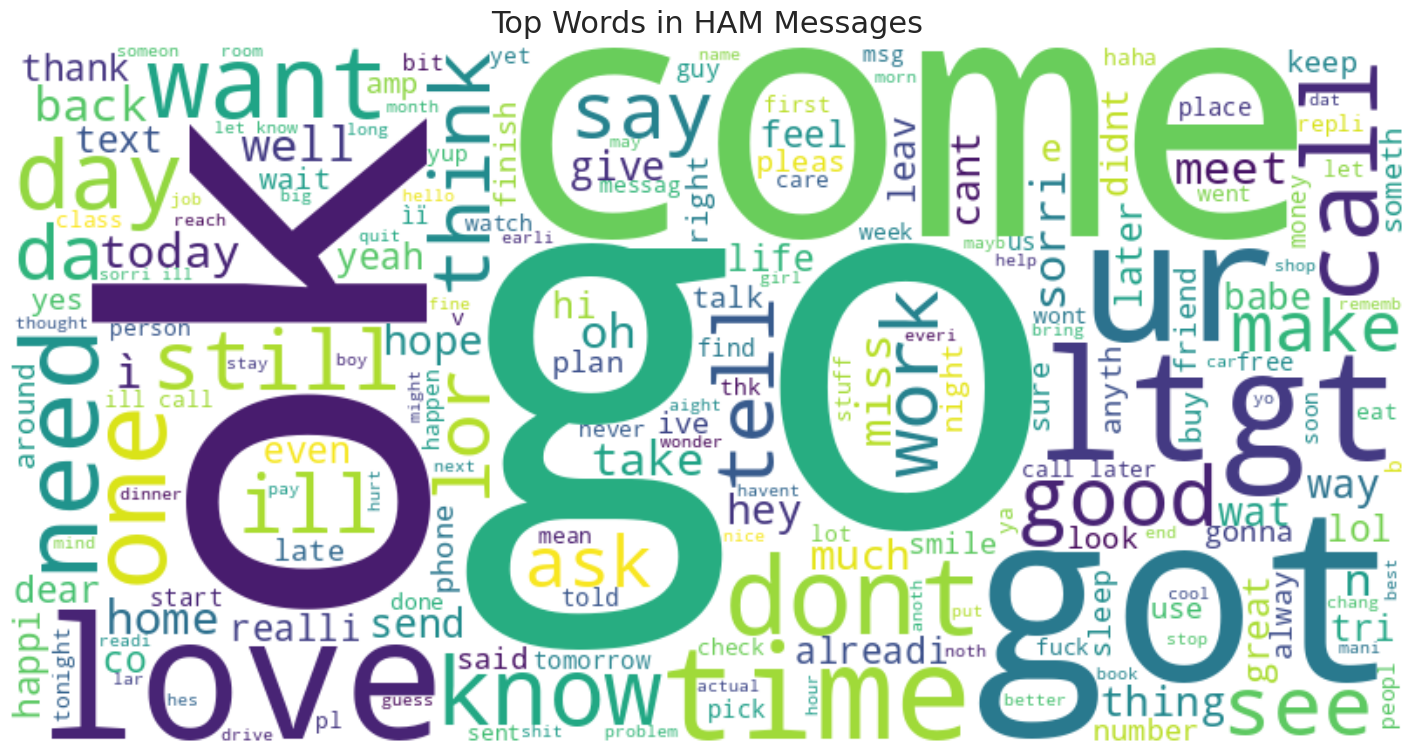

In [14]:
# Purpose: Visualize the most frequent words in HAM messages using WordCloud.

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Initialize the WordCloud object
wordcloud = WordCloud(
    background_color='white',
    max_words=200,
    width=800,
    height=400
)

# Generate the word cloud from HAM messages
ham_text = ' '.join(text for text in df.loc[df['target'] == 'ham', 'message_clean'])
wordcloud.generate(ham_text)

# Plot the WordCloud
plt.figure(figsize=(18, 10))
plt.title(
    'Top Words in HAM Messages',
    fontdict={'size': 22, 'verticalalignment': 'bottom'}
)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


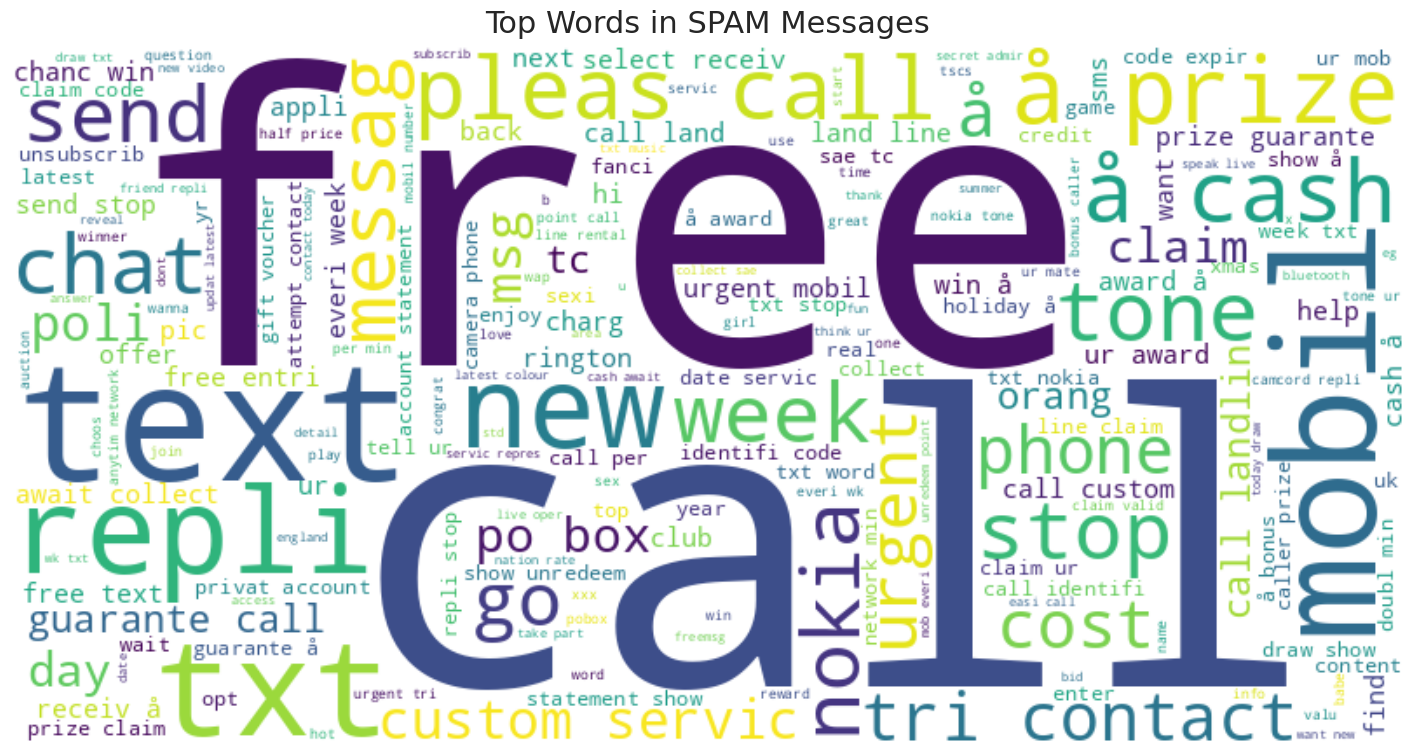

In [15]:
# Purpose: Visualize the most frequent words in SPAM messages using WordCloud.

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Initialize the WordCloud object
wordcloud = WordCloud(
    background_color='white',
    max_words=200,
    width=800,
    height=400
)

# Generate the word cloud from SPAM messages
spam_text = ' '.join(df.loc[df['target'] == 'spam', 'message_clean'])
wordcloud.generate(spam_text)

# Plot the WordCloud
plt.figure(figsize=(18, 10))
plt.title(
    'Top Words in SPAM Messages',
    fontdict={'size': 22, 'verticalalignment': 'bottom'}
)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#**5. Vectorization**

In this section, we convert the text data into a numerical format that machine learning models can understand. This process is called **vectorization**.

We use the **Bag-of-Words (BoW)** approach, which turns each message into a vector of numbers based on word frequency. Here's how it works:

1. Count how many times each word appears in a message.
2. Give less importance to common words that appear in many messages.
3. Make sure the message length doesn't affect the results by normalizing the values.

This will help us prepare the data for building models.

Each message will be represented as a vector, where each position corresponds to a unique word in the dataset. The value in each position shows how many times that word appears in the message.

This creates a large matrix where:
- Rows = text messages
- Columns = unique words (vocabulary)

We’ll use `CountVectorizer` from Scikit-learn to create this matrix of token counts.


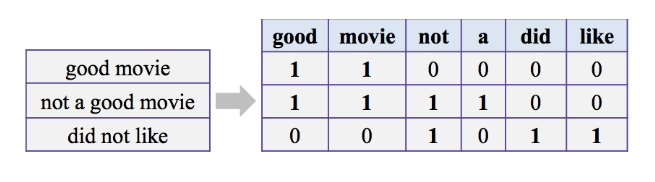

**Vectorization Preparation**

In [16]:
# Define feature and target variables
X = df['message_clean']
y = df['target_encoded']

# Print the lengths to ensure they're aligned
print(f"Number of samples in X: {len(X)}")
print(f"Number of samples in y: {len(y)}")


Number of samples in X: 5572
Number of samples in y: 5572


**Train-Test Split**

In [17]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (default 75/25 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Output the size of each split
print(f"Training set size: {len(X_train)}, {len(y_train)}")
print(f"Test set size: {len(X_test)}, {len(y_test)}")


Training set size: 4179, 4179
Test set size: 1393, 1393


**Count Vectorization (Bag-of-Words)**

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate the CountVectorizer
vectorizer = CountVectorizer()

# Fit the vectorizer on the training data
vectorizer.fit(X_train)

CountVectorizer()

In [19]:
X_train_vec = vectorizer.transform(X_train)
X_test_vec = vectorizer.transform(X_test)

##5.1 Tunning CountVectorizer

`CountVectorizer` includes several parameters to help improve your model by controlling which words are used as features:

1. **stop_words**: Removes common words like "the", "and", "is" that don’t carry much meaning. You can use `stop_words='english'` for a built-in list or provide your own list.

2. **ngram_range**: Controls the size of word groups (n-grams) to include. For example, `ngram_range=(1,2)` will include both single words and 2-word combinations like "data science".

3. **min_df** and **max_df**: These filter out very rare or very common words. For example, `min_df=2` will only include words that appear in at least 2 messages.

4. **max_features**: Limits the number of features (words) to keep, based on their frequency. Helps reduce memory usage and overfitting.


In [20]:
from sklearn.feature_extraction.text import CountVectorizer

# Instantiate the CountVectorizer with tuning parameters
vectorizer_tuned = CountVectorizer(
    stop_words='english',      # Remove common English stop words
    ngram_range=(1, 2),        # Include unigrams and bigrams
    min_df=0.01,               # Only include terms that appear in at least 1% of documents
    max_df=0.7,                # Exclude terms that appear in more than 70% of documents
    max_features=1000          # Limit to the 1000 most frequent features
)

# Fit on the training data
vectorizer_tuned.fit(X_train)

# Transform both training and test data
X_train_vec = vectorizer_tuned.transform(X_train)
X_test_vec = vectorizer_tuned.transform(X_test)


##5.2 TF-IDF


**TF-IDF** (Term Frequency–Inverse Document Frequency) is a method used to measure how important a word is in a specific document compared to all other documents in the dataset.

- **TF (Term Frequency):** How often a word appears in one document.
- **IDF (Inverse Document Frequency):** Reduces the importance of common words that appear in many documents (e.g., "the", "and").


### 🔍 Why is TF-IDF important in our project?

TF-IDF helps by:
- Giving **more weight to meaningful words** that are unique or rare in the corpus.
- **Reducing the impact of frequent but unimportant words**, like "the", "is", or "and".
- Improving the model's ability to **differentiate messages** based on important keywords.

In [21]:
from sklearn.feature_extraction.text import TfidfTransformer

# Initialize the TF-IDF transformer
tfidf_transformer = TfidfTransformer()

# Fit the TF-IDF transformer on the training document-term matrix
tfidf_transformer.fit(X_train_vec)

# Transform the training and test document-term matrices to TF-IDF representation
X_train_tfidf = tfidf_transformer.transform(X_train_vec)
X_test_tfidf = tfidf_transformer.transform(X_test_vec)

# Display the TF-IDF matrix for training data
X_train_tfidf


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 10027 stored elements and shape (4179, 119)>

##5.3 Word Embeddings: GloVe

In [22]:
# Extract cleaned messages and encoded targets from DataFrame
texts = df['message_clean']
target = df['target_encoded']

We need to break the text into smaller parts called **tokens** (like words).  
This process is called **tokenization**.

Tokenization makes the text easier to work with and helps us convert it into numbers, which is needed for machine learning models.


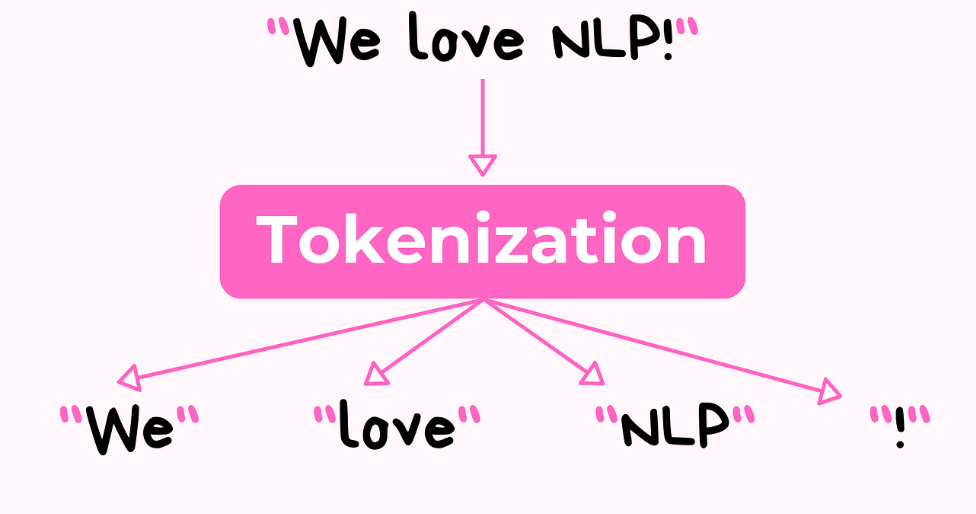

In [23]:
# Initialize the tokenizer and fit on the cleaned texts
from tensorflow.keras.preprocessing.text import Tokenizer

word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

# Calculate the vocabulary size (+1 for padding)
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

6767

**Pad_sequences**

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

```python
tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=None, dtype='int32', padding='pre',
    truncating='pre', value=0.0
)
```

This function transforms a list (of length num_samples) of sequences (lists of integers) into a 2D Numpy array of shape (num_samples, num_timesteps). num_timesteps is either the maxlen argument if provided, or the length of the longest sequence in the list.

```python
>>> sequence = [[1], [2, 3], [4, 5, 6]]
>>> tf.keras.preprocessing.sequence.pad_sequences(sequence, padding='post')
array([[1, 0, 0],
       [2, 3, 0],
       [4, 5, 6]], dtype=int32)
```

In our project, after converting text into sequences of numbers (like word indexes), we need to make sure all sequences have the same size before feeding them into the model. pad_sequences ensures that by:

Padding shorter texts

Truncating longer ones (if needed)

Keeping everything consistent and model-ready

In [43]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1: Fit tokenizer on your corpus
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

# Step 2: Convert texts to sequences of integers
sequences = tokenizer.texts_to_sequences(texts)

# Step 3: Automatically determine the max sequence length
max_len = max(len(seq) for seq in sequences)

# Step 4: Pad all sequences to the max length
train_padded_sentences = pad_sequences(sequences, maxlen=max_len, padding='post')

**GloVe**

GloVe (Global Vectors for Word Representation) is a method for converting words into numbers (vectors) based on how often they appear together in a large collection of text.

We use GloVe to help our model understand the meaning of words by giving it powerful pre-learned word vectors. This improves accuracy and helps the model learn faster and better than using plain numbers or one-hot encoding.

In [30]:
import numpy as np

embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('glove.6B.100d.txt', encoding='utf-8') as fp:
    for line in fp:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions

# Create embedding matrix for words in the tokenizer's vocabulary
# Words not found in GloVe will have a zero vector
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.57832998, -0.0036551 ,  0.34658   , ...,  0.070204  ,
         0.44509   ,  0.24147999],
       [-0.078894  ,  0.46160001,  0.57779002, ...,  0.26352   ,
         0.59397   ,  0.26741001],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

# **6. Modeling**

##**Baseline Model 1: Naive Bayes**

In this baseline model, we use the **Multinomial Naive Bayes** classifier, which is commonly used for text data. We build a pipeline consisting of:

CountVectorizer – Converts raw text into a bag-of-words count matrix.

TfidfTransformer – Applies Term Frequency-Inverse Document Frequency weighting to normalize word importance.

MultinomialNB – Classifies the transformed vectors based on word frequencies.

This model serves as a baseline for comparison with more complex models such as XGBoost, LSTM with GloVe embeddings, and BERT. Despite its simplicity, Naive Bayes often achieves surprisingly strong performance on text classification tasks, especially when the dataset is balanced and well-preprocessed.

**We evaluate the model using accuracy, precision, recall, F1-score, and a confusion matrix.**

## 6.1 Naive Bayes DTM


In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import plotly.figure_factory as ff

# Use the cleaned message and encoded labels
X = df['message_clean']
y = df['target_encoded']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Vectorize the cleaned text
vectorizer = CountVectorizer()
x_train_dtm = vectorizer.fit_transform(X_train)
x_test_dtm = vectorizer.transform(X_test)

# Train Naive Bayes model
nb = MultinomialNB()
nb.fit(x_train_dtm, y_train)

# Make predictions
y_pred = nb.predict(x_test_dtm)

# Evaluate
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1 Score:", metrics.f1_score(y_test, y_pred))

# Plot confusion matrix
def conf_matrix(z):
    x_axes = ['Ham', 'Spam']
    y_axes = ['Spam', 'Ham']
    z = np.flip(z, 0)
    z_text = [[str(val) for val in row] for row in z]

    fig = ff.create_annotated_heatmap(
        z, x=x_axes, y=y_axes,
        annotation_text=z_text, colorscale='Viridis'
    )
    fig.update_layout(
        title_text='<b>Confusion Matrix</b>',
        xaxis=dict(title='Predicted Label'),
        yaxis=dict(title='Actual Label')
    )
    fig['data'][0]['showscale'] = True
    fig.show()

conf_matrix(metrics.confusion_matrix(y_test, y_pred))

Accuracy: 0.9784637473079684
Precision: 0.9398907103825137
Recall: 0.900523560209424
F1 Score: 0.9197860962566845


In [32]:
# Example messages to test
example_messages = [
    "Congratulations! You've won a $1,000 Walmart gift card. Go to [fake-link].com to claim now.",
    "Hey, are we still on for lunch today at 1pm?"
]

# Use the same vectorizer used in training (CountVectorizer)
example_dtm = vectorizer.transform(example_messages)  # vectorizer is already fitted on X_train

# Predict
predictions = nb.predict(example_dtm)

# Map predictions to labels
label_map = {0: "ham", 1: "spam"}
results = [label_map[p] for p in predictions]

# Print results
for msg, pred in zip(example_messages, results):
    print(f"Message: {msg}\nPrediction: {pred}\n")


Message: Congratulations! You've won a $1,000 Walmart gift card. Go to [fake-link].com to claim now.
Prediction: spam

Message: Hey, are we still on for lunch today at 1pm?
Prediction: ham



##6.2 Naive Bayes TF-IDF

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
import numpy as np
import plotly.figure_factory as ff

# Prepare data
X = df['message_clean']
y = df['target_encoded'].astype(str)  # Convert labels to strings for consistency

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Build pipeline
pipe = Pipeline([
    ('bow', CountVectorizer()),
    ('tfid', TfidfTransformer()),
    ('model', MultinomialNB())
])

# Train model
pipe.fit(X_train, y_train)

# Predict
y_pred_class = pipe.predict(X_test)

# Evaluate
print("Accuracy:", metrics.accuracy_score(y_test, y_pred_class))
print("Precision:", metrics.precision_score(y_test, y_pred_class, pos_label='1'))
print("Recall:", metrics.recall_score(y_test, y_pred_class, pos_label='1'))
print("F1 Score:", metrics.f1_score(y_test, y_pred_class, pos_label='1'))

# Confusion matrix function (adapted)
def conf_matrix(z, x=None, y=None):
    x_axes = x if x else ['Ham', 'Spam']
    y_axes = y if y else ['Spam', 'Ham']
    z = np.flip(z, 0)
    z_text = [[str(val) for val in row] for row in z]

    fig = ff.create_annotated_heatmap(
        z, x=x_axes, y=y_axes,
        annotation_text=z_text, colorscale='Viridis'
    )
    fig.update_layout(
        title_text='<b>Confusion Matrix</b>',
        xaxis=dict(title='Predicted Label'),
        yaxis=dict(title='Actual Label')
    )
    fig['data'][0]['showscale'] = True
    fig.show()

# Generate confusion matrix and plot
labels = sorted(list(set(y_test) | set(y_pred_class)))
cm = metrics.confusion_matrix(y_test, y_pred_class, labels=labels)
conf_matrix(cm, x=labels, y=labels)

# Check label types
print("Types in y_test:", set(type(label) for label in y_test))
print("Types in y_pred_class:", set(type(label) for label in y_pred_class))


Accuracy: 0.9597989949748744
Precision: 1.0
Recall: 0.7068062827225131
F1 Score: 0.8282208588957055


Types in y_test: {<class 'str'>}
Types in y_pred_class: {<class 'numpy.str_'>}


##**Baseline Model 2: XGBoost**

XGBoost (Extreme Gradient Boosting) is a high-performance and scalable machine learning algorithm that builds an ensemble of decision trees in a sequential manner to minimize prediction errors. In this project, XGBoost was used as the final classifier in a text classification pipeline, following:

CountVectorizer – to convert raw text into a bag-of-words feature matrix.

TF-IDF Transformer – to reweight the frequency-based features by their importance.

XGBoost Classifier – to learn complex patterns from the transformed features.

##  6.3 XGBoost

In [ ]:
pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 5.6 MB/s eta 0:00:27
    --------------------------------------- 2.1/150.0 MB 7.3 MB/s eta 0:00:21
   - -------------------------------------- 5.5/150.0 MB 10.8 MB/s eta 0:00:14
   -- ------------------------------------- 7.9/150.0 MB 11.0 MB/s eta 0:00:13
   -- ------------------------------------- 10.0/150.0 MB 10.7 MB/s eta 0:00:14
   --- ------------------------------------ 12.1/150.0 MB 10.8 MB/s eta 0:00:13
   --- ------------------------------------ 14.4/150.0 MB 10.8 MB/s eta 0:00:13
   ---- ----------------------------------- 16.5/150.0 MB 10.7 MB/s eta 0:00:13
   ----- ---------------------------------- 18.9/150.0 MB 10.8 MB/s eta 0:00:13
   ----- ---------------------------------- 21.5/150.0 MB 10.9 MB/s eta 0:00:12
   ------ --------------------------------- 23.9/150.0 MB 10.9 MB/s eta 0:00:12
   ------- -------------------------------- 26.5/150.0 


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import metrics
from sklearn.metrics import classification_report  # imported here, since you use it later

# Define the pipeline with CountVectorizer, TF-IDF Transformer, and XGBoost classifier
pipe = Pipeline([
    ('bow', CountVectorizer()),
    ('tfid', TfidfTransformer()),
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc',
    ))
])

# Convert target labels to integers
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Fit the pipeline on training data
pipe.fit(X_train, y_train)

# Predict on test data
y_pred_class = pipe.predict(X_test)

# Predict on training data to check for overfitting
y_pred_train = pipe.predict(X_train)

# Print accuracy scores
print('Train Accuracy: {:.4f}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test Accuracy: {:.4f}'.format(metrics.accuracy_score(y_test, y_pred_class)))

# Precision, Recall, F1-score
print("\nClassification Report (Test Data):\n")
print(classification_report(y_test, y_pred_class, digits=4))

# Plot confusion matrix using your earlier function
conf_matrix(metrics.confusion_matrix(y_test, y_pred_class))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[17:36:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Train Accuracy: 0.9830
Test Accuracy: 0.9648

Classification Report (Test Data):

              precision    recall  f1-score   support

           0     0.9645    0.9958    0.9799      1202
           1     0.9671    0.7696    0.8571       191

    accuracy                         0.9648      1393
   macro avg     0.9658    0.8827    0.9185      1393
weighted avg     0.9649    0.9648    0.9631      1393



In [35]:
# Example messages to test
example_messages = [
    "Congratulations! You've won a $1,000 Walmart gift card. Go to [fake-link].com to claim now.",
    "Hey, are we still on for lunch today at 1pm?"
]

# Predict using the pipeline directly (pipe includes vectorizer and model)
predictions = pipe.predict(example_messages)

# Map predictions to labels
label_map = {0: "ham", 1: "spam"}
results = [label_map[p] for p in predictions]

# Print results
for msg, pred in zip(example_messages, results):
    print(f"Message: {msg}\nPrediction: {pred}\n")


Message: Congratulations! You've won a $1,000 Walmart gift card. Go to [fake-link].com to claim now.
Prediction: spam

Message: Hey, are we still on for lunch today at 1pm?
Prediction: ham



##**Advanced Model: LSTM with GloVe**

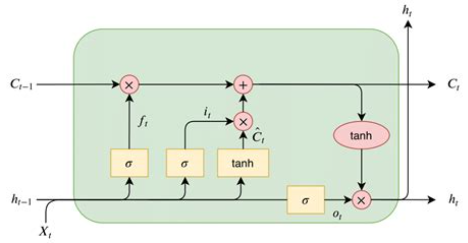

LSTM (Long Short-Term Memory) networks are a type of Recurrent Neural Network (RNN) specifically designed to capture long-range dependencies and temporal patterns in sequential data, such as natural language.

In this project, the LSTM model was used to classify text data by processing word sequences and learning contextual relationships between tokens. The architecture typically includes:

Embedding Layer – to map input words to dense vector representations.

LSTM Layer – to capture sequential dependencies in the text.

Dense Output Layer – to produce the final classification probabilities.

In [36]:
# Model architecture adapted from:
# https://www.kaggle.com/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/data

In [37]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences,
    target,
    test_size=0.25
)

In [48]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout,
    GlobalMaxPool1D, Bidirectional, BatchNormalization
)


def glove_lstm(embedding_matrix, sequence_length):
    """
    Build an LSTM model with pretrained GloVe embeddings.

    Args:
        embedding_matrix (np.array): Pretrained embedding weights.
        sequence_length (int): Length of input sequences.

    Returns:
        model (tf.keras.Model): Compiled Keras model.
    """
    model = Sequential()

    # Add embedding layer with pretrained weights; allow fine-tuning
    model.add(
        Embedding(
            input_dim=embedding_matrix.shape[0],  # Vocabulary size
            output_dim=embedding_matrix.shape[1],  # Embedding vector size
            weights=[embedding_matrix],
            input_length=sequence_length,
            trainable=True,
        )
    )

    # Add bidirectional LSTM layer with recurrent dropout
    model.add(
        Bidirectional(
            LSTM(
                units=sequence_length,
                return_sequences=True,
                recurrent_dropout=0.2,
            )
        )
    )

    # Global max pooling to reduce sequence dimension
    model.add(GlobalMaxPool1D())

    # Normalize activations to improve training stability
    model.add(BatchNormalization())

    # Dropout to reduce overfitting
    model.add(Dropout(0.5))

    # Fully connected dense layer with ReLU activation
    model.add(Dense(sequence_length, activation="relu"))
    model.add(Dropout(0.5))

    # Another dense layer with ReLU and dropout
    model.add(Dense(sequence_length, activation="relu"))
    model.add(Dropout(0.5))

    # Final output layer with sigmoid activation for binary classification
    model.add(Dense(1, activation="sigmoid"))

    # Compile the model with RMSprop optimizer and binary cross-entropy loss
    model.compile(
        optimizer="rmsprop",
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    return model


# Instantiate the model with embedding matrix and max sequence length
model = glove_lstm(embedding_matrix, max_len)

# Print the model summary
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │       676,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_2          │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 676,700 (2.58 MB)

 Trainable params: 676,700 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, LSTM, Dense, Dropout,
    GlobalMaxPool1D, Bidirectional, BatchNormalization
)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau


def glove_lstm():
    """
    Build and compile a Bidirectional LSTM model using pretrained GloVe embeddings.

    Returns:
        model (tf.keras.Model): Compiled Keras model.
    """
    model = Sequential()

    # Embedding layer with pretrained weights (trainable)
    model.add(
        Embedding(
            input_dim=embedding_matrix.shape[0],
            output_dim=embedding_matrix.shape[1],
            weights=[embedding_matrix],
            input_length=X_train.shape[1],  # Set input sequence length
            trainable=True,  # Set to False to freeze embeddings
        )
    )

    # Bidirectional LSTM with recurrent dropout
    model.add(
        Bidirectional(
            LSTM(
                units=64,
                return_sequences=True,
                recurrent_dropout=0.2,
            )
        )
    )

    # Pooling and regularization
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    # Fully connected hidden layers
    model.add(Dense(64, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.5))

    # Output layer for binary classification
    model.add(Dense(1, activation="sigmoid"))

    # Compile model with optimizer and loss
    model.compile(
        optimizer="rmsprop",
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    return model


# Instantiate the model
model = glove_lstm()

# Define callbacks
checkpoint = ModelCheckpoint(
    filepath="best_model.h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min"
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=25,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint, reduce_lr],
    verbose=1
)

Epoch 1/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.7305 - loss: 0.6206
Epoch 1: val_loss improved from inf to 0.39747, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 49s 271ms/step - accuracy: 0.7311 - loss: 0.6193 - val_accuracy: 0.8787 - val_loss: 0.3975 - learning_rate: 0.0010
Epoch 2/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9027 - loss: 0.2607
Epoch 2: val_loss improved from 0.39747 to 0.21710, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 44s 293ms/step - accuracy: 0.9028 - loss: 0.2605 - val_accuracy: 0.9440 - val_loss: 0.2171 - learning_rate: 0.0010
Epoch 3/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9457 - loss: 0.1645
Epoch 3: val_loss improved from 0.21710 to 0.12746, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 41s 294ms/step - accuracy: 0.9457 - loss: 0.1645 - val_accuracy: 0.9533 - val_loss: 0.1275 - learning_rate: 0.0010
Epoch 4/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9612 - loss: 0.1306
Epoch 4: val_loss improved from 0.12746 to 0.10134, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 257ms/step - accuracy: 0.9612 - loss: 0.1306 - val_accuracy: 0.9655 - val_loss: 0.1013 - learning_rate: 0.0010
Epoch 5/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9731 - loss: 0.0869
Epoch 5: val_loss improved from 0.10134 to 0.07377, saving model to best_model.h5


131/131 ━━━━━━━━━━━━━━━━━━━━ 35s 269ms/step - accuracy: 0.9730 - loss: 0.0870 - val_accuracy: 0.9785 - val_loss: 0.0738 - learning_rate: 0.0010
Epoch 6/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9801 - loss: 0.0669
Epoch 6: val_loss did not improve from 0.07377
131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 257ms/step - accuracy: 0.9801 - loss: 0.0669 - val_accuracy: 0.9749 - val_loss: 0.0872 - learning_rate: 0.0010
Epoch 7/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9781 - loss: 0.0634
Epoch 7: val_loss did not improve from 0.07377
131/131 ━━━━━━━━━━━━━━━━━━━━ 42s 266ms/step - accuracy: 0.9781 - loss: 0.0634 - val_accuracy: 0.9813 - val_loss: 0.0876 - learning_rate: 0.0010
Epoch 8/25
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9777 - loss: 0.0731
Epoch 8: val_loss did not improve from 0.07377

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
131/131 ━━━━━━━━━━━━━━━━━━━━ 34s 259ms/step - accuracy: 0.9777 - loss: 0.0730 - val_a

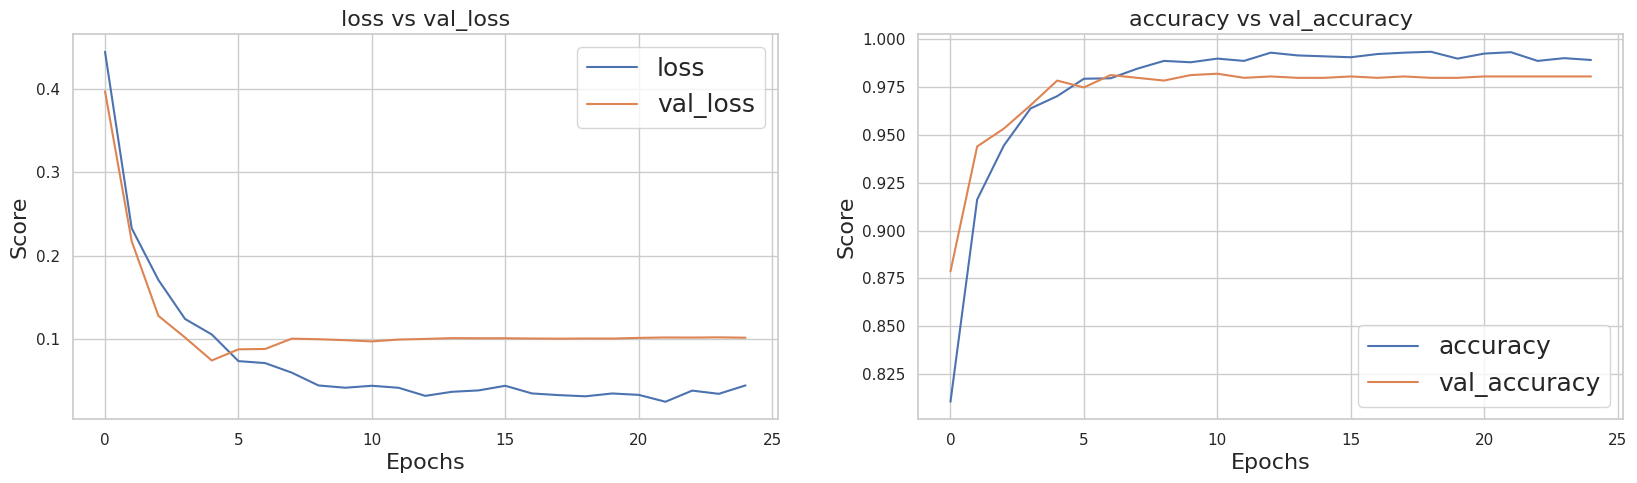

In [50]:
def plot_learning_curves(history, arr):
    """
    Plots the learning curves for training and validation metrics.

    Parameters:
    - history: The History object returned by model.fit() in Keras.
    - arr: A list of two lists. Each inner list contains two strings:
           the metric name and its validation counterpart.
           Example: [['loss', 'val_loss'], ['accuracy', 'val_accuracy']]
    """
    # Create two subplots side by side
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))

    for idx in range(2):
        # Plot training and validation metric values
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])

        # Add a legend for clarity
        ax[idx].legend([arr[idx][0], arr[idx][1]], fontsize=18)

        # Set labels and title
        ax[idx].set_xlabel('Epochs', fontsize=16)
        ax[idx].set_ylabel('Score', fontsize=16)
        ax[idx].set_title(f"{arr[idx][0]} vs {arr[idx][1]}", fontsize=16)

# Example usage: plot training/validation loss and accuracy
plot_learning_curves(history, [['loss', 'val_loss'], ['accuracy', 'val_accuracy']])


44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step
Classification Report:
              precision    recall  f1-score   support

           0     0.9851    0.9925    0.9888      1196
           1     0.9521    0.9086    0.9299       197

    accuracy                         0.9806      1393
   macro avg     0.9686    0.9506    0.9593      1393
weighted avg     0.9804    0.9806    0.9804      1393

Confusion Matrix:
[[1187    9]
 [  18  179]]


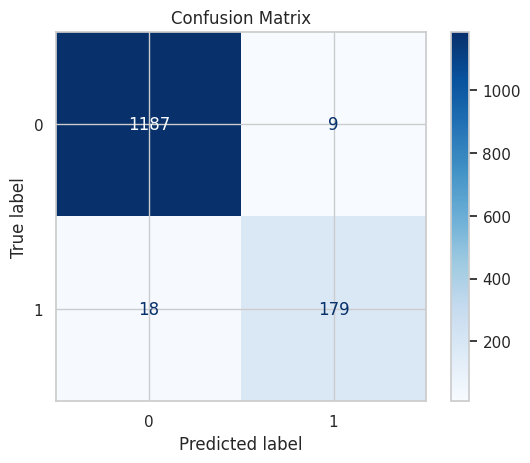

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


High Accuracy (98.06%) indicates that most predictions are correct.

In [59]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Example messages
custom_messages = [
    "Congratulations! You've won a $1,000 Walmart gift card. Go to [fake-link].com to claim now.",
    "Hey, are we still on for lunch today at 1pm?"
]

# Preprocess messages: clean, tokenize, pad
def preprocess_messages(messages, tokenizer, max_len):
    # You can use the same clean_text function if used during training
    cleaned = [clean_text(msg) for msg in messages]
    sequences = tokenizer.texts_to_sequences(cleaned)
    padded = pad_sequences(sequences, maxlen=max_len)
    return padded

# Preprocess custom messages
X_custom = preprocess_messages(custom_messages, tokenizer, max_len)

# Predict
pred_probs = model.predict(X_custom)
pred_labels = (pred_probs > 0.5).astype(int)

# Map predictions to labels (assuming 1=spam, 0=ham)
label_map = {1: 'spam', 0: 'ham'}

# Show predictions
for msg, label, prob in zip(custom_messages, pred_labels, pred_probs):
    print(f"Message: {msg}\nPrediction: {label_map[int(label)]} (Confidence: {float(prob):.4f})\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Message: Congratulations! You've won a $1,000 Walmart gift card. Go to [fake-link].com to claim now.
Prediction: spam (Confidence: 0.7579)

Message: Hey, are we still on for lunch today at 1pm?
Prediction: ham (Confidence: 0.0000)



<ipython-input-59-6d6cf0ddc11f>:30: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



##**7. Model Comparison**

In [56]:
import pandas as pd

# Create the results table
results = pd.DataFrame({
    'Model': [
        'Naive Bayes (DTM)',
        'Naive Bayes (TF-IDF)',
        'XGBoost',
        'LSTM'
    ],
    'Accuracy': [0.978464, 0.959799, 0.964824, 0.9806],
    'Precision': [0.939891, 1.000000, 0.9671, 0.9521],
    'Recall': [0.900524, 0.706806, 0.7696, 0.9086],
    'F1 Score': [0.919786, 0.828221, 0.857143, 0.9299]
})

# Print the table
print("\n📊 Model Comparison Table:")
print(results.to_string(index=False))



📊 Model Comparison Table:
               Model  Accuracy  Precision   Recall  F1 Score
   Naive Bayes (DTM)  0.978464   0.939891 0.900524  0.919786
Naive Bayes (TF-IDF)  0.959799   1.000000 0.706806  0.828221
             XGBoost  0.964824   0.967100 0.769600  0.857143
                LSTM  0.980600   0.952100 0.908600  0.929900


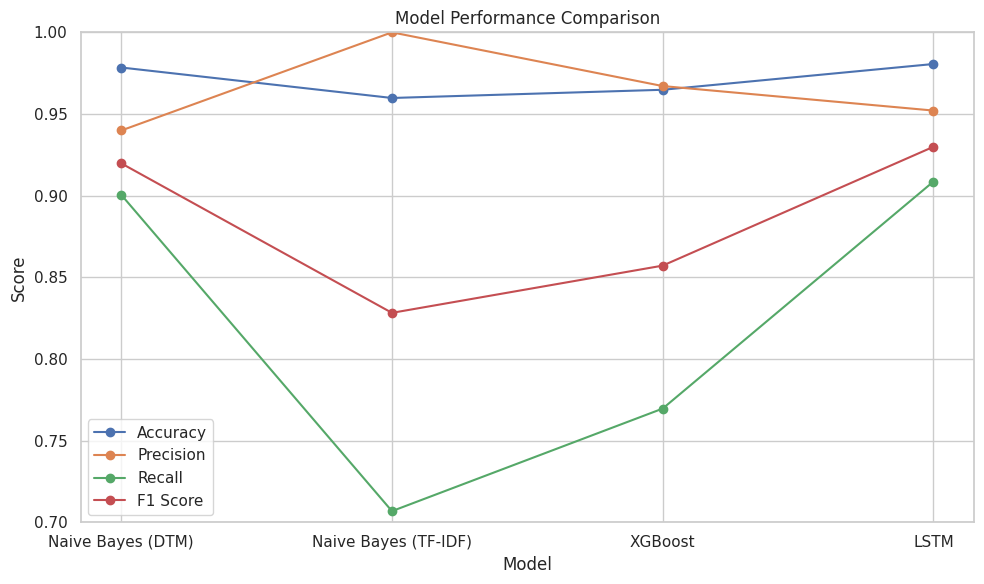

In [57]:
# Plot the comparison chart
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x_labels = results['Model']

plt.figure(figsize=(10, 6))

for metric in metrics:
    plt.plot(x_labels, results[metric], marker='o', label=metric)

plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0.7, 1.0)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

**The chart above compares the performance of Naive Bayes (using both DTM and TF-IDF), XGBoost, and LSTM models across four metrics: Accuracy, Precision, Recall, and F1 Score.**

**Insights:**

**LSTM performed the best overall,** achieving the highest Accuracy (0.9806), Recall (0.9086), and F1 Score (0.9299), demonstrating superior classification capability, especially in identifying positive cases.

**Naive Bayes with DTM** showed very strong Accuracy (0.9785) and balanced Precision (0.9399) and Recall (0.9005), making it a reliable baseline model.

**Naive Bayes with TF-IDF** achieved perfect Precision (1.0) but relatively lower Recall (0.7068), indicating it was very precise when predicting positives but missed some positive cases.

**XGBoost** exhibited high Precision (0.9671) and good overall Accuracy (0.9648), but a lower Recall (0.7696), suggesting it is conservative in positive predictions and may miss some positive instances.

##**8. Hyperparameter Tuning**

###**Tuned XGBoost Classifier**

We achieved a notable accuracy increase **from 0.9648 to 0.9830**



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[18:34:24] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Accuracy:  0.9830
Precision: 0.9645
Recall:    0.9067
F1 Score:  0.9347

Classification Report:

              precision    recall  f1-score   support

           0     0.9856    0.9948    0.9902       965
           1     0.9645    0.9067    0.9347       150

    accuracy                         0.9830      1115
   macro avg     0.9751    0.9507    0.9625      1115
weighted avg     0.9828    0.9830    0.9827      1115



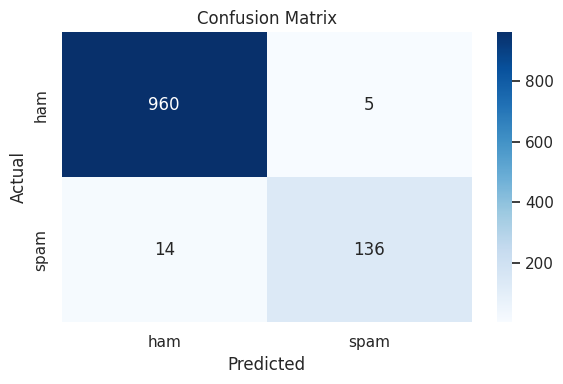

In [58]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from xgboost import XGBClassifier

# Text cleaning function
def clean_text(text):
    """
    Clean text by removing URLs, HTML tags, punctuation,
    and extra whitespaces. Converts text to lowercase.
    """
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>', '', text)                  # Remove HTML
    text = re.sub(r'[^a-z\s]', '', text)               # Remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()           # Normalize whitespace
    return text


# Clean the text column
df['message_clean'] = df['message'].apply(clean_text)

# Vectorize text data using TF-IDF
tfidf = TfidfVectorizer(max_features=10000)
X = tfidf.fit_transform(df['message_clean'])

# Encode target labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['target'])

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)

# Initialize XGBoost classifier
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=7,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=1.0,
    gamma=0,
    reg_alpha=1,
    reg_lambda=2,
    random_state=2,
    use_label_encoder=False,
    eval_metric='logloss',
)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

# Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

We improved the spam detection model's accuracy by applying two key enhancements:

**Advanced Text Preprocessing:** Cleaned the messages by removing URLs, punctuation, HTML tags, and by normalizing case and whitespace. This eliminated noise and resulted in cleaner, more informative input.

**Tuned XGBoost Parameters:** Increased n_estimators to 300 and applied regularization (reg_alpha=1, reg_lambda=2) with max_depth=7 to enhance learning while reducing overfitting. Additionally, the TfidfVectorizer was refined with max_features=10000 to extract richer and more relevant text features.